In [1]:
from glob import glob
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import SkewT
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [12]:
file_name = 'data/NUCAPS-EDR_v3r0_j01_s202211170044310_e202211170045010_c202211170121580.nc'

nucaps = xr.open_dataset(file_name, engine='h5netcdf', decode_times=False)

nucaps['Time']=nucaps['Time']/1000.0
nucaps.Time.attrs = {'units': 'seconds since 1970-01-01'}
nucaps = xr.decode_cf(nucaps)

In [13]:
footprint = nucaps.sel(Number_of_CrIS_FORs=82)

print(footprint.Time.values)

T = np.flip(footprint.Temperature.values.flatten())*units('K')
T=T.to(units.celsius)
MR = np.flip(footprint.H2O_MR.values.flatten())*units('kg/kg')
P = np.flip(footprint.Pressure.values.flatten())*units('millibar')
H = mpcalc.pressure_to_height_std(P).to(units.m)

2022-11-17T00:44:52.382999296


In [14]:
RH = mpcalc.relative_humidity_from_mixing_ratio(P, T, MR)
Td = mpcalc.dewpoint_from_relative_humidity(T, RH)

/home/rebekah/miniconda3/envs/notebook_demo/lib/python3.11/site-packages/metpy/calc/thermo.py:1114: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


In [15]:
Psurf = footprint.Surface_Pressure.item()*units('millibar')
mask = (P < Psurf) & (P >= 100*units('millibar'))

In [16]:
timestr = footprint.Time.dt.strftime('%d %b %Y %H:%M UTC').item()
locstr = "("+str(footprint.Latitude.values.round(1))+"$^\circ$N, "+str(np.abs(footprint.Longitude.values.round(1)))+"$^\circ$W)"

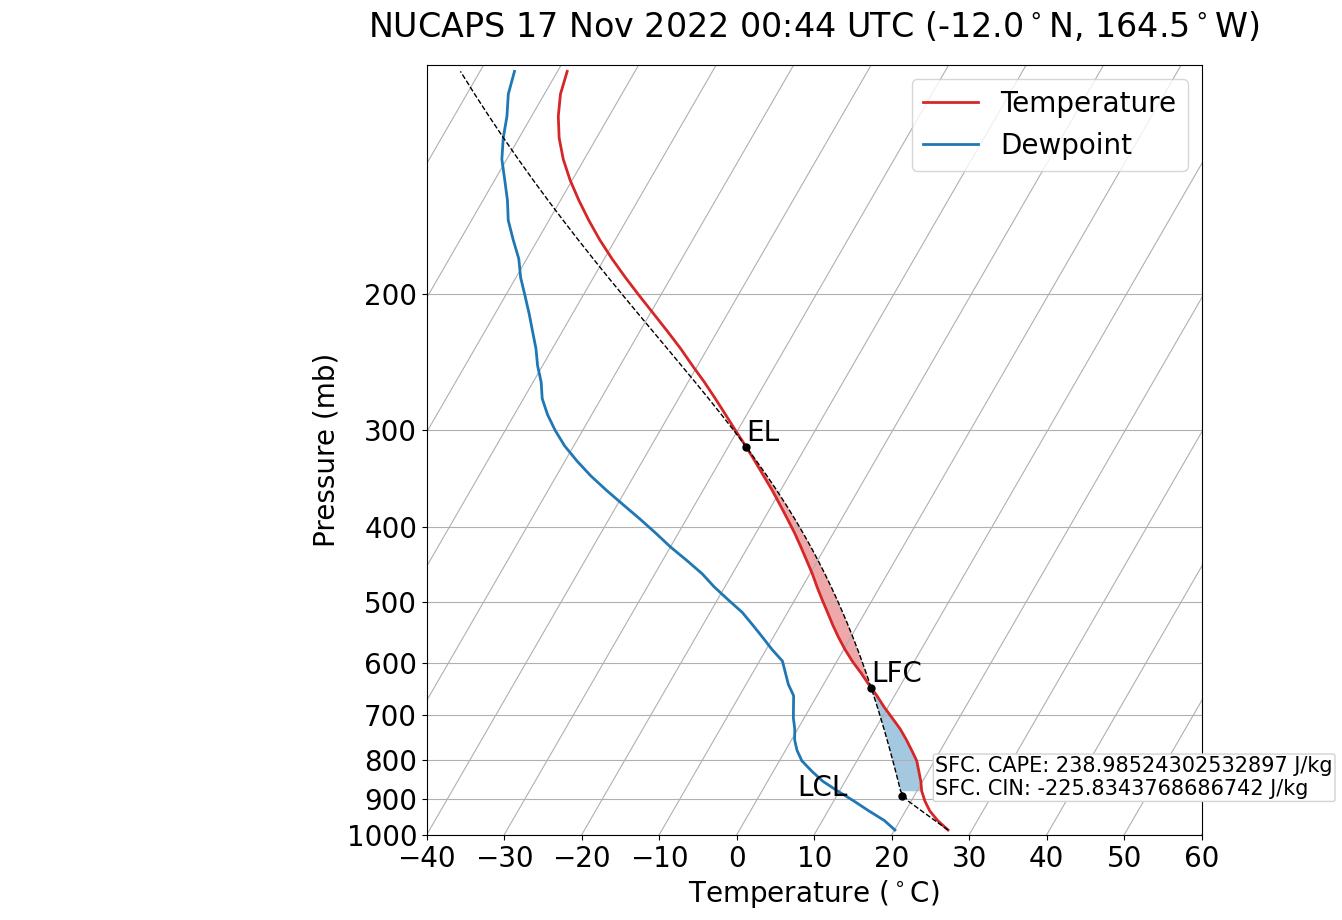

In [19]:
plt.rcParams.update({'font.size': 20})

P1 = P[mask]
T1 = T[mask]
Td1 = Td[mask]

# Shade CAPE/CIN
prof = mpcalc.parcel_profile(P1, T1[0], Td1[0]).to('degC')

# Calc lcl, cape vals
lcl_pressure, lcl_temperature = mpcalc.lcl(P1[0], T1[0], Td1[0])
lfc_pressure, lfc_temperature = mpcalc.lfc(P1, T1, Td1)
el_pressure, el_temperature = mpcalc.el(P1, T1, Td1)

sfc_cape, sfc_cin = mpcalc.surface_based_cape_cin(P1, T1, Td1)
mlcape, mlcin = mpcalc.mixed_layer_cape_cin(P1, T1, Td1)

# label = 'SFC. CAPE: '+str(sfc_cape.magnitude.round())+' J/kg\n'+'SFC. CIN: '+str(sfc_cin.magnitude.round())+' J/kg'
# label = label+'\nML. CAPE: '+str(mlcape.magnitude.round())+' J/kg\n'+'ML. CIN: '+str(mlcin.magnitude.round())+' J/kg'

# Make plot -------
fig = plt.figure(figsize=(10,10))
skew = SkewT(fig, aspect='auto')

skew.plot(P1, T1, label='Temperature', color='tab:red', lw=2)
skew.plot(P1, Td1, label='Dewpoint',  color='tab:blue', lw=2)

skew.ax.legend(loc='upper right')

skew.ax.set_ylim(1000, 101)
skew.ax.set_xlim(-40, 60)

# Plot LCL
skew.plot(el_pressure, el_temperature, marker='.', c='k', markersize=10)
skew.plot(lfc_pressure, lfc_temperature, marker='.', c='k', markersize=10)
skew.plot(lcl_pressure, lcl_temperature, marker='.', c='k', markersize=10)

# ax = plt.gca()
skew.ax.annotate('EL', xy=(el_temperature, el_pressure), va="bottom", ha="left")
skew.ax.annotate('LFC', xy=(lfc_temperature, lfc_pressure), va="bottom", ha="left")
skew.ax.annotate('LCL', xy=(5, lcl_pressure))

skew.ax.annotate(label, xy=(23, 900), va="bottom", ha="left", size=15, bbox=dict(boxstyle="round, pad=0.1", fc="white", ec="lightgrey", lw=1))

# Plot Profile
skew.plot(P1, prof, c='k', linewidth=1, markersize=1, linestyle='dashed')

# Shade areas of CAPE and CIN
skew.shade_cin(P1, T1, prof, Td1)
skew.shade_cape(P1, T1, prof)

# ax = plt.gca()
skew.ax.set_xlabel('Temperature ($^\circ$C)')
skew.ax.set_ylabel('Pressure (mb)')
skew.ax.set_title("NUCAPS "+timestr+" "+locstr, pad=20)

plt.show()

In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [ ]:
plot_projection =ccrs.Orthographic(central_longitude=-75.2)
data_projection = ccrs.PlateCarree()

qc = (nucaps.Quality_Flag.values == 0)

plt.figure(figsize=[8,8])
ax = plt.subplot(projection=plot_projection)
ax.coastlines()
tmp = ax.scatter(nucaps.Longitude.values[qc], nucaps.Latitude.values[qc], c=np.array(cape)[qc], transform=data_projection)
plt.colorbar(tmp, shrink=0.8)
plt.show()